# Cart Pole Control Using Q-Learning
(Custom Environment, Using First Order Euler Discretization, no Gymnasium)

![alt text](cartpole.png)
![alt text](cartpole-formulas.png)

The goal is to control the Cart Pole by applying
a horizontal force to the cart such that the pole remains balanced in the
upright position.

Tasks:
1. __Perform the discretization of the mathematical model in the state space__
2. __Define the space of actions. Action space should be discreet and limited.__
3. __Choose the method of formation of the reward.__
4. __Train the agent using Q-Learning or SARSA.__
5. __Simulate the environment and display the obtained results. You don't have to make a visualization.__

# Basic Imports

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# Cart Pole Environment

Tasks 1, 2, 3:

In [91]:
class CartPoleEnv:
    def __init__(self, T = 0.02, k = 1/3):
        '''
            T - discretization time step (0.02 -> 50 steps in a second)
            k - constant related to the moment of inertia of the lever
            g - gravity
            m - mass of the lever
            M - mass of the cart + mass of the lever
            l - length of the lever
            F - force magnitude in N
        '''
        self.g = 9.81
        self.m = 0.1
        self.M = 1.1
        self.l = 0.5
        self.F = 10.0
        self.T = T
        self.k = k


        '''
            Termination tresholds
            x_treshold - if the cart goes off the rails
            theta_treshold - if the angle is too big
        '''
 
        self.x_treshold = 2.4  
        self.theta_threshold = 0.21  # ~12 degrees

        self.actions = [-self.F, self.F]  #push to the left, push to the right

        self.reset()


    def reset(self):
        '''
            The start of the episode
            State is defined by x, x_dot, theta, theta_dot
            x - position
            x_dot - velocity
            theta - angle between the pole and vertical axis
            theta_dot - angular velocity, how fast the angle is changing
        '''
        self.state = np.array([0.0, 0.0, 0.05, 0.0])  #small angle and no movement
        return self.state
    
    def step(self, action):

        x, x_dot, theta, theta_dot = self.state
        force = action

        sin_theta = np.sin(theta)
        cos_theta = np.cos(theta)

        numerator_tdd = self.M * self.g * sin_theta - cos_theta * (force + self.m * self.l * theta_dot**2 * sin_theta)
        denominator_tdd = (1 + self.k) * self.M * self.l - self.m * self.l * cos_theta**2

        numerator_xdd = self.m * self.g * sin_theta * cos_theta - (1 + self.k) * (force + self.m * self.l * theta_dot**2 * sin_theta)
        denominator_xdd = self.m * cos_theta**2 - (1 + self.k) * self.M

        '''
            x_dd - acceleration
            theta_dd - angular acceleration
        '''
        theta_dd = numerator_tdd / denominator_tdd
        x_dd = numerator_xdd / denominator_xdd


        # First order Euler discretization  xk+1 = xk + xk_dot * T
        x += x_dot * self.T
        x_dot += x_dd * self.T
        theta += theta_dot * self.T
        theta_dot += theta_dd * self.T

        #update the state 
        self.state = np.array([x, x_dot, theta, theta_dot])

        #get the reward and check if the episode is done
        reward = self.get_reward()
        done = self.is_done()

        return self.state, reward, done


    def is_done(self):
        x, _, theta, _ = self.state
        return abs(theta) > abs(self.theta_threshold) or abs(x) > abs(self.x_treshold)

    def get_reward(self):
        ''' a reward with a value of +1 is awarded for each step of the simulation. The more steps in the episode elapse before 
            occurrence of a terminal condition, the reward for that episode will be higher.  Gymnasium type reward function.'''

        return 1.0
    
    

Q-Learning cannot work with real numbers directly. So discretization is needed. 

# Finite state space for Q-Learning

In [92]:
class StateDiscretizer:
    def __init__(self):
        # 1 dimensional bins
        self.x_bins = np.linspace(-2.4, 2.4, 6)
        self.x_dot_bins = np.linspace(-3.0, 3.0, 6)
        self.theta_bins = np.linspace(-0.21, 0.21, 12)   # interval from -0.21 to 0.21 rad
        self.theta_dot_bins = np.linspace(-3.0, 3.0, 6)

    def discretize(self, state):
        # mapping to a descrete index (for each state component)
        x, x_dot, theta, theta_dot = state
        return (  #index in Q table
            np.digitize(x, self.x_bins),
            np.digitize(x_dot, self.x_dot_bins),
            np.digitize(theta, self.theta_bins),
            np.digitize(theta_dot, self.theta_dot_bins)
        )
    # Q table ->  Q[x_i][xdot_i][θ_i][θdot_i][action]

    @property
    def state_space_size(self):
        # dimension of Q table
        return (
            len(self.x_bins) + 1,
            len(self.x_dot_bins) + 1,
            len(self.theta_bins) + 1,
            len(self.theta_dot_bins) + 1
        )


Task 4:

# Q-Learning Agent

In [93]:
class QLearningAgent:
    def __init__(self, state_space, action_space):
        ''' 
            state_space - dimensions of the discrete state space
            action_space - possible actions
            alpha - learning rate
            gamma - discount factor
            epsilon - probability of a random action
            Q - Q table
        '''

        self.alpha = 0.1
        self.gamma = 0.99
        # When epsilon = 1, the epsilon-greedy policy chooses actions completely randomly, so it is equivalent to a random policy.
        self.epsilon = 1.0   
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.actions = action_space # [-10, +10]

        # Q table ->  Q[x_i][xdot_i][θ_i][θdot_i][action]
        self.Q = np.zeros(state_space + (len(action_space),))


    def choose_action(self, state):
        '''
            Actions are selected using an epsilon-greedy policy,
            so that exploration and exploitation are balanced.
        '''
        if np.random.rand() < self.epsilon:   
            # Exploration - choose a random action
            return np.random.randint(len(self.actions))
        # Exploitation with probability 1-epsilon, the agent is using his current knowledge to maximize rewards
        return np.argmax(self.Q[state]) 
    
    def update(self, s, a, r, s_next):
        '''Q-values are updated using the Bellman optimality equation
            s - state, tuple
            a - action, 0 or 1
            r - reward
            s_next - next state
        '''
        self.Q[s + (a,)] += self.alpha * (r + self.gamma * np.max(self.Q[s_next]) - self.Q[s + (a,)])



# Training

In [94]:
env = CartPoleEnv()
discretizer = StateDiscretizer()
agent = QLearningAgent(
    state_space=discretizer.state_space_size,
    action_space=env.actions
)

episodes = 3000
episode_rewards = []

for ep in range(episodes):
    state = env.reset()
    s_disc = discretizer.discretize(state) # state discretization
    total_reward = 0

    while True:
        action_idx = agent.choose_action(s_disc)
        next_state, reward, done = env.step(env.actions[action_idx])
        s_next_disc = discretizer.discretize(next_state)

        agent.update(s_disc, action_idx, reward, s_next_disc)  # update Q values

        s_disc = s_next_disc
        total_reward += reward

        if done:
            break

    agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
    episode_rewards.append(total_reward)


In [95]:
# Training statistics
avg_reward = np.mean(episode_rewards)
max_reward = np.max(episode_rewards)
min_reward = np.min(episode_rewards)

print(f"Training statistics over {episodes} episodes:")
print(f"Average reward per episode: {avg_reward:.2f}")
print(f"Maximum reward achieved: {max_reward}")
print(f"Minimum reward achieved: {min_reward}")
print(f"Average number of steps per episode: {avg_reward:.2f}")


Training statistics over 3000 episodes:
Average reward per episode: 56.69
Maximum reward achieved: 106.0
Minimum reward achieved: 9.0
Average number of steps per episode: 56.69


Task 5:

Visualizing rewards

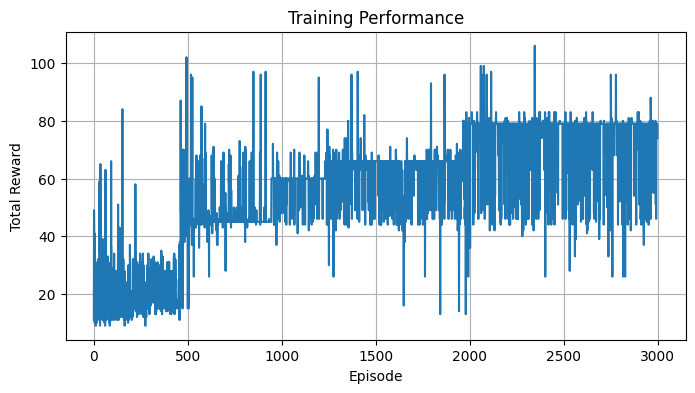

In [96]:
plt.figure(figsize=(8,4))
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance")
plt.grid()
plt.show()

Testing the learned policy

In [97]:
state = env.reset()
trajectory = []  #saves states throughout the episode

#simulating one episode with 300 steps
for _ in range(300):
    trajectory.append(state.copy())
    s_disc = discretizer.discretize(state)
    action_idx = np.argmax(agent.Q[s_disc])  # the agent chooses the best learned action
    state, _, done = env.step(env.actions[action_idx])
    if done:
        break

trajectory = np.array(trajectory)


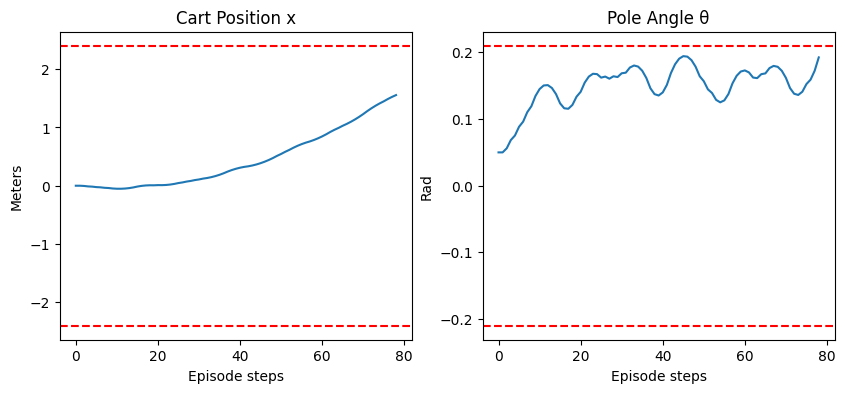

In [98]:
# how the position and the angle change in one particular test episode
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(trajectory[:,0])
plt.axhline(y=env.x_treshold, color='r', linestyle='--')
plt.axhline(y=-env.x_treshold, color='r', linestyle='--')
plt.title("Cart Position x")
plt.xlabel("Episode steps")
plt.ylabel("Meters")

plt.subplot(1,2,2)
plt.plot(trajectory[:,2])
plt.axhline(y=env.theta_threshold, color='r', linestyle='--')
plt.axhline(y=-env.theta_threshold, color='r', linestyle='--')
plt.title("Pole Angle θ")
plt.xlabel("Episode steps")
plt.ylabel("Rad")

plt.show()


System remained stable. Agent is capable of remaining the cart on the rails and pole upright.

Simulating an episode with 50 steps

In [99]:
state = env.reset()

print("Step |   x     |  x_dot  |  theta  | theta_dot | action")
print("----------------------------------------------------------")

for step in range(50):
    s_disc = discretizer.discretize(state)
    action_idx = np.argmax(agent.Q[s_disc])
    action = env.actions[action_idx]

    state, reward, done = env.step(action)

    print(f"{step:>4} | "
          f"{state[0]:>7.3f} | "
          f"{state[1]:>7.3f} | "
          f"{state[2]:>7.3f} | "
          f"{state[3]:>9.3f} | "
          f"{'RIGHT' if action > 0 else 'LEFT'}")

    if done:
        print("\nEpisode terminated.")
        break


Step |   x     |  x_dot  |  theta  | theta_dot | action
----------------------------------------------------------
   0 |   0.000 |  -0.196 |   0.050 |     0.308 | LEFT
   1 |  -0.004 |  -0.392 |   0.056 |     0.616 | LEFT
   2 |  -0.012 |  -0.197 |   0.068 |     0.342 | RIGHT
   3 |  -0.016 |  -0.393 |   0.075 |     0.655 | LEFT
   4 |  -0.024 |  -0.199 |   0.088 |     0.387 | RIGHT
   5 |  -0.028 |  -0.396 |   0.096 |     0.706 | LEFT
   6 |  -0.035 |  -0.202 |   0.110 |     0.445 | RIGHT
   7 |  -0.039 |  -0.398 |   0.119 |     0.771 | LEFT
   8 |  -0.047 |  -0.205 |   0.135 |     0.518 | RIGHT
   9 |  -0.052 |  -0.012 |   0.145 |     0.270 | RIGHT
  10 |  -0.052 |   0.181 |   0.150 |     0.027 | RIGHT
  11 |  -0.048 |   0.373 |   0.151 |    -0.215 | RIGHT
  12 |  -0.041 |   0.566 |   0.147 |    -0.456 | RIGHT
  13 |  -0.029 |   0.759 |   0.137 |    -0.699 | RIGHT
  14 |  -0.014 |   0.562 |   0.124 |    -0.367 | LEFT
  15 |  -0.003 |   0.365 |   0.116 |    -0.038 | LEFT
  16 |   0.0